In [20]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

In [21]:
def w_alpha(x, alpha):
    a = 2 - alpha
    b = alpha
    x = np.clip(x, 1e-12, 1-1e-12)
    return x**(a-1) * (1-x)**(b-1) / sp.beta(a, b)

def Q_jacobi(x, alpha, n):
    t = 2*x - 1
    return sp.jacobi(n-1, alpha-1, 1-alpha)(t)

def w_eps(x, alpha, n, eps):
    return (1 + eps * Q_jacobi(x, alpha, n)) * w_alpha(x, alpha)

def lambda_bk_numeric(b, k, alpha, n, eps=0.0, measure="beta", N=4000):
    x = np.linspace(1e-9, 1-1e-9, N)

    if measure == "beta":
        w = w_alpha(x, alpha)
    elif measure == "eps":
        w = w_eps(x, alpha, n, eps)
    else:
        raise ValueError("measure must be 'beta' or 'eps'")

    integrand = x**(k-2) * (1-x)**(b-k) * w
    val = np.trapz(integrand, x)

    return max(val, 0.0)


def build_rates(n, alpha, eps=0.0, measure="beta", forbid_star=True):
    r = {b: {} for b in range(2, n+1)}
    lam = {}

    for b in range(2, n+1):
        total = 0.0

        for k in range(2, b+1):

            if forbid_star and (b > 2) and (k == b):
                continue

            val = lambda_bk_numeric(
                b, k, alpha,
                n=n,
                eps=eps,
                measure=measure
            )
            r[b][k] = val
            total += val

        lam[b] = max(total, 1e-14)

    return r, lam


def simulate_tau(n, nsim, r, lam, rng):
    taus = np.empty(nsim)
    for s in range(nsim):
        b = n
        t = 0.0
        while b > 1:
            lb = lam[b]
            if lb <= 0:
                break
            t += rng.exponential(1.0 / lb)
            ks = list(r[b].keys())
            probs = np.array([r[b][k] for k in ks], float)
            tot = probs.sum()
            if tot == 0:
                break
            probs /= tot
            k = rng.choice(ks, p=probs)
            b = b - k + 1
        taus[s] = t
    return taus

In [22]:
def build_R_matrix(n, r, lam):
    m = n - 1
    R = np.zeros((m, m))
    for b in range(2, n+1):
        i = b - 2
        R[i, i] = -lam[b]
        for k in r[b]:
            newb = b - k + 1
            if newb >= 2:
                j = newb - 2
                R[i, j] += r[b][k]
    return R

def density_from_R(R, t):
    m = len(R)
    p = np.zeros(m)
    p[-1] = 1.0  # départ: b=n
    ones = np.ones(m)
    dt = t[1] - t[0]
    f = np.zeros_like(t)
    for i in range(1, len(t)):
        k1 = p @ R
        k2 = (p + 0.5*dt*k1) @ R
        k3 = (p + 0.5*dt*k2) @ R
        k4 = (p + dt*k3) @ R
        p = p + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        f[i] = -(p @ (R @ ones))
    return np.clip(f, 0, None)

In [23]:
# Approximation de sup |Q_{n-1}(x)|
def compute_sup_Q(alpha, n, grid_size=20000):
    x = np.linspace(0, 1, grid_size)
    Q = Q_jacobi(x, alpha, n)
    M = np.max(np.abs(Q))
    return M

# epsilon_max = 1 / M
def compute_eps_max(alpha, n):
    M = compute_sup_Q(alpha, n)
    return 1 / M

# Test pour plusieurs alpha
def eps_table(n, alphas):
    print(f"n = {n}")
    print("alpha     epsilon_max")
    print("----------------------")
    for alpha in alphas:
        eps_max = compute_eps_max(alpha, n)
        print(f"{alpha:.4f}   {eps_max:.6f}")

# Exemple
alphas = [1.1, 1.2, 1.4, 1.6, 1.8, 1.999]
eps_table(n=8, alphas=alphas)


n = 8
alpha     epsilon_max
----------------------
1.1000   0.777168
1.2000   0.611927
1.4000   0.392062
1.6000   0.260454
1.8000   0.178215
1.9990   0.125215


In [43]:
def run_experiments(n, eps_list, nsim, alphas):
    x = np.linspace(0, 1, 1000)
    nrows = len(alphas)
    fig, axes = plt.subplots(nrows, 2, figsize=(12, 4 * nrows))

    if nrows == 1:
        axes = np.array([axes])

    # Nouvelle palette (pastel + contrastes harmonieux & daltonisme OK)
    # ε = 0 : rose pâle / histogramme encore plus clair
    baseline_color = "#F6C1C9"          # courbe baseline
    baseline_hist_color = "#FBE5EA"     # remplissage histogramme baseline
    # ε > 0 : bleu indigo et orange chaud (distincts, lisibles)
    eps_colors = ["#3B5B92", "#D95F02"]

    for row, alpha in enumerate(alphas):
        axL, axR = axes[row]

        w0 = w_alpha(x, alpha)
        axL.plot(x, w0, color=baseline_color, linewidth=1.8, label="$\\varepsilon=0$")

        for idx, eps in enumerate(eps_list):
            we = w_eps(x, alpha, n, eps)
            color = eps_colors[idx % len(eps_colors)]
            legend_label = f"$\\varepsilon={eps}$"
            axL.plot(x, we, color=color, linewidth=1.6, label=legend_label)

        axL.set_xlabel("x")
        axL.set_ylabel("Densité")
        axL.set_title(f"Densités $\\Lambda_{{\\varepsilon}}^{{\\alpha}}$ pour $\\alpha={alpha}$")
        axL.legend(fontsize=9, frameon=True)
        axL.set_xlim(0, 1)
        if alpha == 1.0:
            axL.set_ylim(0.5, 1.5)
        else:
            axL.set_ylim(0, np.quantile(w0, 0.99) * 1.3)

        r0, lam0 = build_rates(n, alpha, measure="beta")
        R0 = build_R_matrix(n, r0, lam0)
        rng0 = np.random.default_rng(1000 + row)
        taus0 = simulate_tau(n, nsim, r0, lam0, rng0)

        all_taus = [taus0]
        taus_eps_list = []

        for idx, eps in enumerate(eps_list):
            re, lame = build_rates(n, alpha, eps=eps, measure="eps")
            rnge = np.random.default_rng(2000 + row * 10 + idx)
            tause = simulate_tau(n, nsim, re, lame, rnge)
            all_taus.append(tause)
            taus_eps_list.append((eps, tause))

        tmax = np.quantile(np.concatenate(all_taus), 0.995)
        t = np.linspace(0, tmax, 300)
        f0 = density_from_R(R0, t)

        bins = np.linspace(0, tmax, 40)
        axR.hist(taus0, bins=bins, density=True, color=baseline_hist_color, alpha=0.75,
                 label="Empirique $\\varepsilon=0$")

        for idx, (eps, tause) in enumerate(taus_eps_list):
            color = eps_colors[idx % len(eps_colors)]
            legend_label = f"Empirique $\\varepsilon={eps}$"
            axR.hist(tause, bins=bins, density=True, histtype="step", linewidth=1.4,
                     color=color, label=legend_label)

        axR.plot(t, f0, linestyle="--", color="#000000", linewidth=1, label="Théorie $\\varepsilon=0$")

        axR.set_xlabel("TMRCA (unité de temps)")
        axR.set_ylabel("Densité")
        axR.set_title(f"Distribution du TMRCA pour $\\alpha={alpha}$")
        axR.legend(fontsize=9, frameon=True)

    fig.tight_layout()
    plt.show()
    fig.savefig("LaTeX/photo/plot_foret_pas_grande_beta_combined.svg")
    fig.savefig("LaTeX/photo/plot_foret_pas_grande_beta_combined.png", dpi=300)

C:\Users\Le R\AppData\Local\Temp\ipykernel_17984\884736518.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  val = np.trapz(integrand, x)


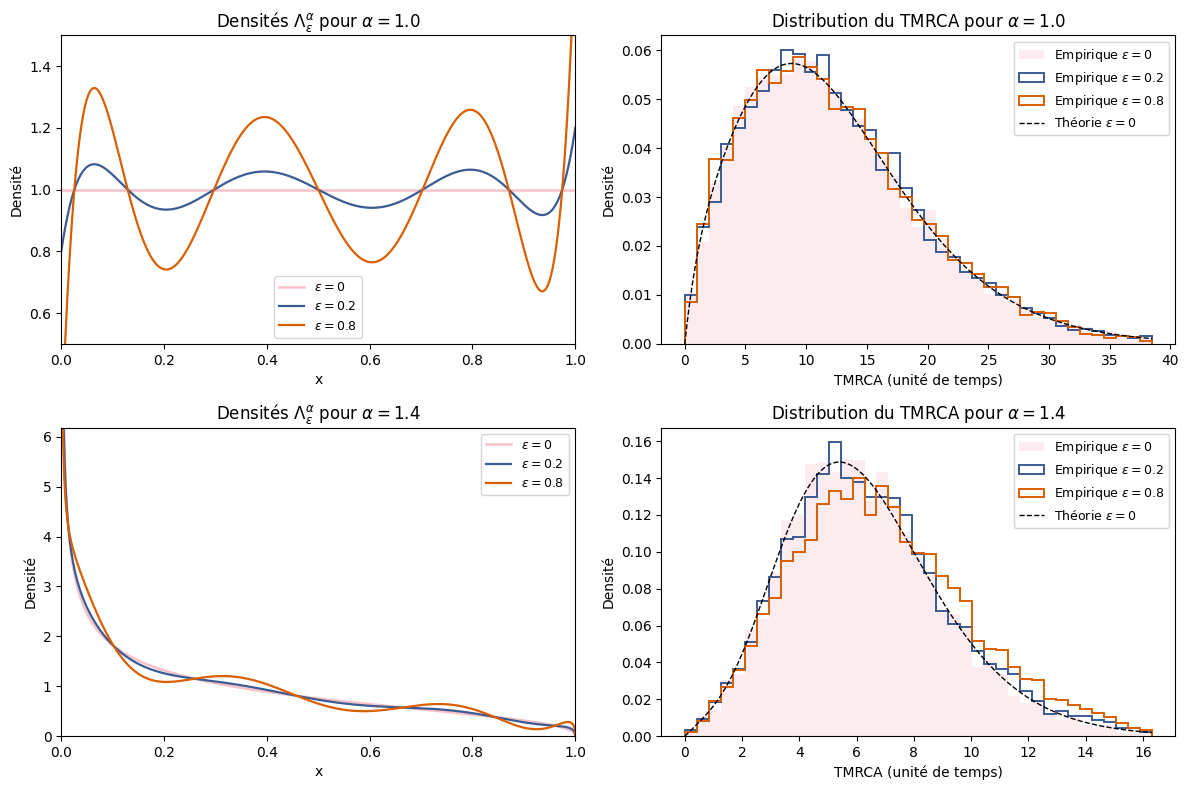

In [45]:
run_experiments(
    n=8,
    eps_list=[0.2, 0.8],
    nsim=8000,
    alphas=[1.0, 1.4]
)